In [1]:
# ------------------------------
# PROYECTO ML - SERIES TEMPORALES (LSTM)
# ------------------------------

# Paso 1: Carga y limpieza del dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Leer el CSV original
df = pd.read_csv("/home/adria/Project_break_2_ML/ML_Flights_MAD/src/data_sample/estat_avia_par_es_filtered_en.csv", low_memory=False)
df = df[df['airp_pr'].str.count(" - ") == 1].copy()
df[['Origen', 'Destino']] = df['airp_pr'].str.split(" - ", expand=True)
df['fecha'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
df = df[df['Origen'].str.contains("MADRID", case=False, na=False) |
        df['Destino'].str.contains("MADRID", case=False, na=False)]
df['ruta'] = df['Origen'] + " → " + df['Destino']
df_lstm = df.pivot_table(index='fecha', columns='ruta', values='OBS_VALUE', aggfunc='sum').fillna(0).sort_index()


2025-04-02 19:25:47.021638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743614747.054301  413891 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743614747.063789  413891 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 19:25:47.120046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Paso 2: Filtrar rutas con al menos 10 años de datos
rutas_10y = (df_lstm != 0).sum()
rutas_10y = rutas_10y[rutas_10y > 120].index.tolist()
df_subset = df_lstm[rutas_10y]

In [3]:
# Paso 3: Separar entrenamiento y test (2024)
df_train = df_subset[df_subset.index < "2024-01-01"]
df_test = df_subset[df_subset.index >= "2024-01-01"]

In [4]:
# Paso 4: Escalado y generación de secuencias
scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
X_train, y_train = df_train_scaled.values, df_train_scaled.values
n_steps = 12
generator = TimeseriesGenerator(X_train, y_train, length=n_steps, batch_size=16)


In [6]:
# Paso 5: Modelo LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_steps, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.fit(generator, epochs=400, callbacks=[EarlyStopping(monitor='loss', patience=30)], verbose=1)


Epoch 1/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2282
Epoch 2/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1153
Epoch 3/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0930
Epoch 4/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0635
Epoch 5/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0541
Epoch 6/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0585
Epoch 7/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0612
Epoch 8/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0542
Epoch 9/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0485
Epoch 10/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0486
Epoch 11/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0463
Epoch 12/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0323
Epoch 13/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0400
Epoch 14/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0370
Epoch 15/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - lo

In [7]:
# Paso 6: Predicción autorregresiva para 2024
input_seq = df_train_scaled.values[-n_steps:]
forecast_input = input_seq.copy()
future_preds = []
for i in range(12):
    input_batch = forecast_input[-n_steps:].reshape((1, n_steps, X_train.shape[1]))
    pred_scaled = model.predict(input_batch, verbose=0)
    forecast_input = np.vstack([forecast_input, pred_scaled])
    future_preds.append(pred_scaled)
future_preds_scaled = np.vstack(future_preds)
future_preds_real = scaler.inverse_transform(future_preds_scaled)
last_date = df_train.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
df_pred_2024 = pd.DataFrame(future_preds_real, columns=df_train.columns, index=future_dates)
df_real_2024 = df_test.loc[future_dates]

In [8]:
# Paso 7: Evaluación y comparación con modelo naive
errores = []
naive_preds = pd.DataFrame(index=df_pred_2024.index, columns=df_pred_2024.columns)
for ruta in df_pred_2024.columns:
    ultimo_valor = df_train[ruta].iloc[-1]
    naive_preds[ruta] = [ultimo_valor] * 12
    y_true = df_real_2024[ruta].values
    y_lstm = df_pred_2024[ruta].values
    y_naive = naive_preds[ruta].values
    errores.append({
        'ruta': ruta,
        'MAE_LSTM': mean_absolute_error(y_true, y_lstm),
        'RMSE_LSTM': np.sqrt(mean_squared_error(y_true, y_lstm)),
        'MAE_Naive': mean_absolute_error(y_true, y_naive),
        'RMSE_Naive': np.sqrt(mean_squared_error(y_true, y_naive)),
    })

df_errores = pd.DataFrame(errores).sort_values('RMSE_LSTM')
df_errores.to_csv("/home/adria/Project_break_2_ML/ML_Flights_MAD/src/results/errores_comparacion_modelos.csv", index=False)
df_pred_2024.to_csv("/home/adria/Project_break_2_ML/ML_Flights_MAD/src/results/predicciones_lstm_2024.csv")
df_real_2024.to_csv("/home/adria/Project_break_2_ML/ML_Flights_MAD/src/results/valores_reales_2024.csv")


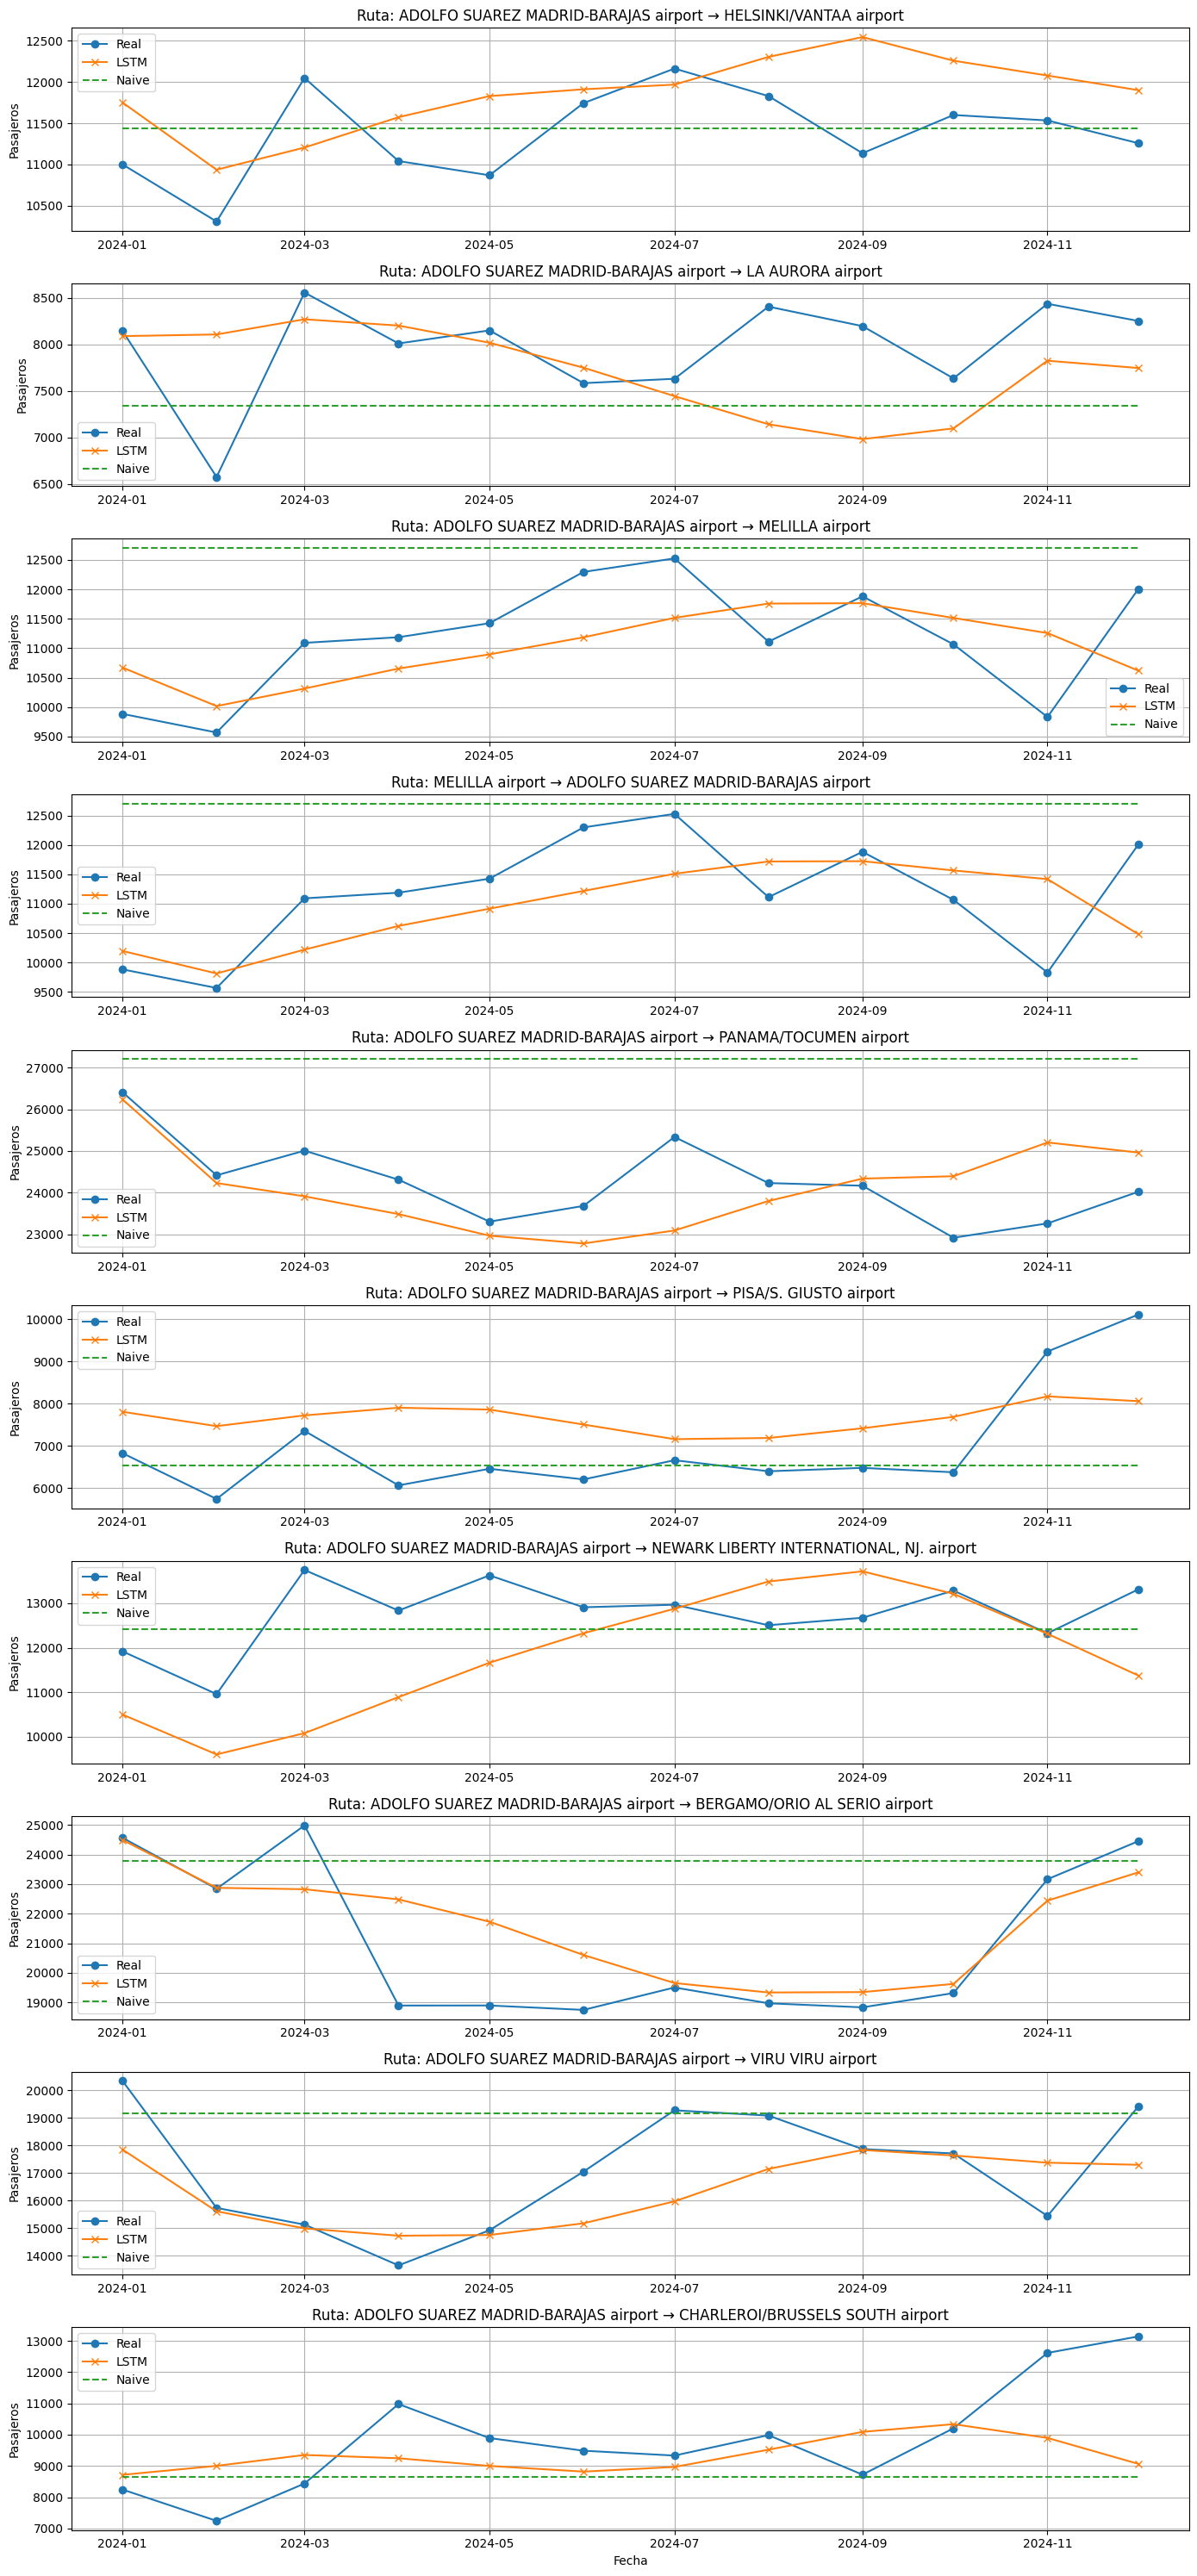

In [10]:
# Paso 8: Visualización de top 10 predicciones
top_10 = df_errores.head(10)['ruta'].tolist()
plt.figure(figsize=(14, 30))
for i, ruta in enumerate(top_10):
    plt.subplot(10, 1, i + 1)
    plt.plot(df_real_2024[ruta], label="Real", marker='o')
    plt.plot(df_pred_2024[ruta], label="LSTM", marker='x')
    plt.plot(naive_preds[ruta], label="Naive", linestyle='--')
    plt.title(f"Ruta: {ruta}")
    plt.ylabel("Pasajeros")
    plt.grid(True)
    plt.legend()
plt.xlabel("Fecha")
plt.tight_layout()
plt.savefig("/home/adria/Project_break_2_ML/ML_Flights_MAD/src/results/comparativa_predicciones.png")